In [ ]:
from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, AutoFeatureExtractor, \
                         AutoTokenizer, TrainingArguments, Trainer

In [ ]:
!pip install datasets

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
import torch
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize
import pandas as pd
import requests
from io import BytesIO

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    'google/vit-base-patch16-224-in21k',
    'distilgpt2'
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.2.cr

In [ ]:
type(model.encoder)

transformers.models.vit.modeling_vit.ViTModel

In [ ]:
type(model.decoder)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

In [ ]:
total_params = 0
for param in model.parameters():
    total_params += torch.numel(param)

print(f'Our model has a combined {total_params:,} parameters')

Our model has a combined 182,485,248 parameters


In [ ]:
import os
import shutil

# Create the .kaggle directory if not exists
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json file to this directory
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Set permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

FileNotFoundError: [Errno 2] No such file or directory: 'kaggle.json'

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.02G/1.04G [00:06<00:00, 131MB/s]
100% 1.04G/1.04G [00:06<00:00, 180MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("flickr8k.zip", "r") as zip_ref:
    zip_ref.extractall("flickr8k")

In [ ]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')

In [ ]:
for i in range(5):
  with open('/content/flickr8k/captions.txt') as caption_file:
    caption_data = caption_file.readlines()
    line = caption_data[i]
    line = line.rstrip("\n")
    print(line)
    # Image name and captions are separated using a tab
    img_name, caption = line.split(",")
    print(img_name)
    print(caption)


image,caption
image
caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg
A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg
A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg
A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg
A little girl climbing the stairs to her playhouse .


In [ ]:
IMAGES_PATH = '/content/flickr8k/Images'
MIN_CAPTION, MAX_CAPTION = 10, 50
def load_captions_data(filename):
  i = 0
  with open(filename) as caption_file:
    caption_data = caption_file.readlines()
    caption_mapping = {}
    text_data = []

    for line in caption_data:
      i = i + 1
      if i > 8000:
        break
      line = line.rstrip("\n")
      # Image name and captions are separated using a tab
      img_name, caption = line.split(",",1)

      # Each image is repeated five times for five different captions.
      # Each image name has a suffix '#(caption number)'
      img_name = img_name.split('#')[0]
      img_name = os.path.join(IMAGES_PATH, img_name.strip())

      if img_name.endswith("jpg"):
        caption = caption.replace(' .','').strip()
        tokens = caption.strip().split()
        if len(caption) < MIN_CAPTION or len(caption) > MAX_CAPTION:
          continue
        text_data.append(caption)

        if img_name in caption_mapping:
          caption_mapping[img_name].append(caption)
        else:
          caption_mapping[img_name] = [caption]

    return caption_mapping, text_data

# Load the dataset
captions_mapping, text_data = load_captions_data('/content/flickr8k/captions.txt')

In [ ]:
list(captions_mapping.items())[:5]

[('/content/flickr8k/Images/1000268201_693b08cb0e.jpg',
  ['A girl going into a wooden building',
   'A little girl climbing into a wooden playhouse',
   'A little girl climbing the stairs to her playhouse']),
 ('/content/flickr8k/Images/1001773457_577c3a7d70.jpg',
  ['A black dog and a spotted dog are fighting',
   'Two dogs on pavement moving toward each other']),
 ('/content/flickr8k/Images/1003163366_44323f5815.jpg',
  ['A man lays on a bench while his dog sits by him',
   'A shirtless man lies on a park bench with his dog']),
 ('/content/flickr8k/Images/1007129816_e794419615.jpg',
  ['A man in an orange hat starring at something',
   'A man wears an orange hat and glasses']),
 ('/content/flickr8k/Images/1007320043_627395c3d8.jpg',
  ['A child playing on a rope net', 'A little girl climbing on red roping'])]

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
normalize = Normalize(
    feature_extractor.image_mean,
    feature_extractor.image_std
)

_transforms = Compose([
    Resize((feature_extractor.size['height'], feature_extractor.size['width'])),   # Data augmentation: Take a random resized crop of our image
    ToTensor(),                                  # Convert to pytorch tensor
    normalize                                    # normalize pixel values to look like images during pre-training
])

In [ ]:
rows = []

# I am ok using multiple captions per image because of our data augmentation

for path, captions in captions_mapping.items():
  for caption in captions:
    rows.append({
        'path': path,
        'caption': caption
    })

image_df = pd.DataFrame(rows)
image_dataset = Dataset.from_pandas(image_df)

In [ ]:
image_df.shape

(3873, 2)

In [ ]:
image_df.head()

,path,caption
0,/content/flickr8k/Images/1000268201_693b08cb0e...,A girl going into a wooden building
1,/content/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing into a wooden playhouse
2,/content/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing the stairs to her playh...
3,/content/flickr8k/Images/1001773457_577c3a7d70...,A black dog and a spotted dog are fighting
4,/content/flickr8k/Images/1001773457_577c3a7d70...,Two dogs on pavement moving toward each other


In [ ]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

def image_preprocess(examples):
  # ViT expects pixel_values instead of input_ids
  examples['pixel_values'] = [_transforms(Image.open(path)) for path in examples['path']]

  # We are padding tokens here instead of using a datacollator
  tokenized = gpt2_tokenizer(examples['caption'], padding='max_length', max_length = 10, truncation = True)['input_ids']

  # the output captions
  examples['labels'] = [[l if l != gpt2_tokenizer.pad_token_id else -100 for l in t] for t in tokenized]

  # delete unused keys
  del examples['path']
  del examples['caption']

  return examples

In [ ]:
image_dataset = image_dataset.map(image_preprocess, batched = True)

Map:   0%|          | 0/3873 [00:00<?, ? examples/s]

In [ ]:
image_dataset = image_dataset.train_test_split(test_size = 0.1)

In [ ]:
image_dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 3485
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 388
    })
})

In [ ]:
# We set a pad token and a start token in our combined model to be the same as gpt2
model.config.pad_token = gpt2_tokenizer.pad_token
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

model.config.decoder_start_token = gpt2_tokenizer.bos_token
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id

In [ ]:
# freeze all but the last two layers in the ViT
for name, param in model.encoder.named_parameters():
  if 'encoder.layer.10' in name:
    break
  param.requires_grad = False

In [ ]:
# Modify the compute_loss method in the Trainer class
from transformers.trainer import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # add num_items_in_batch
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.
        Subclass and override for custom behavior.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)  # Remove num_items_in_batch here
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir = './v2_image_captioning', # the output directory
    overwrite_output_dir = True,          # overwrite the content of the output directory
    num_train_epochs = 4,                 # number of training epochs
    per_device_train_batch_size = 64,     # batch size for training
    per_device_eval_batch_size = 64,      # batch size for evaluation
    load_best_model_at_end = True,
    log_level = 'info',
    logging_steps = 50,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch'
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=image_dataset['train'],
    eval_dataset=image_dataset['test']
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 388
  Batch size = 64


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


{'eval_loss': 5.070819854736328,
 'eval_model_preparation_time': 0.0078,
 'eval_runtime': 50.7375,
 'eval_samples_per_second': 7.647,
 'eval_steps_per_second': 0.138}

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 3,485
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 220
  Number of trainable parameters = 110,863,872


Epoch,Training Loss,Validation Loss,Model Preparation Time
1,3.699900,3.190790,0.007800
2,3.138400,3.027363,0.007800
3,2.917400,2.967914,0.007800



***** Running Evaluation *****
  Num examples = 388
  Batch size = 64


Saving model checkpoint to ./v2_image_captioning/checkpoint-55
Configuration saved in ./v2_image_captioning/checkpoint-55/config.json
Configuration saved in ./v2_image_captioning/checkpoint-55/generation_config.json
Model weights saved in ./v2_image_captioning/checkpoint-55/model.safetensors

***** Running Evaluation *****
  Num examples = 388
  Batch size = 64
Saving model checkpoint to ./v2_image_captioning/checkpoint-110
Configuration saved in ./v2_image_captioning/checkpoint-110/config.json
Configuration saved in ./v2_image_captioning/checkpoint-110/generation_config.json
Model weights saved in ./v2_image_captioning/checkpoint-110/model.safetensors

***** Running Evaluation *****
  Num examples = 388
  Batch size = 64
Saving model checkpoint to ./v2_image_captioning/checkpoint-165
Configuration saved in ./v2_image_captioning/checkpoint-165/config.json
Configuration saved in ./v2_image_captioning/checkpoint-165/generation_config.json
Model weights saved in ./v2_image_captioning/chec

In [ ]:
trainer.save_model()

In [ ]:
finetuned_model = VisionEncoderDecoderModel.from_pretrained('./v2_image_captioning/checkpoint-165')

In [ ]:
# create a new composition that doesn't crop images for inference to make it easier for the model
inference_transforms = Compose(
    [
        Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
        ToTensor(),
        Normalize(
            feature_extractor.image_mean,
            feature_extractor.image_std
        )
    ]
)

In [ ]:
# a helper function to caption images from the web or a file path
def caption_image(m, path):
  if 'http' in path:
    response = requests.get(path)
    img = Image.open(BytesIO(response.content))
    image_matrix = inference_transforms(img).unsqueeze(0)
  else:
    img = Image.open(path)
    image_matrix = inference_transforms(img).unsqueeze(0)

  generated = m.generate(
      image_matrix,
      num_beams = 3,
      max_length = 15,
      early_stopping = True,
      do_sample = True,
      top_k = 10,
      num_return_sequences = 2
  )

  caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens = True).strip() for g in generated]
  display(img)
  return caption_options, generated, image_matrix

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


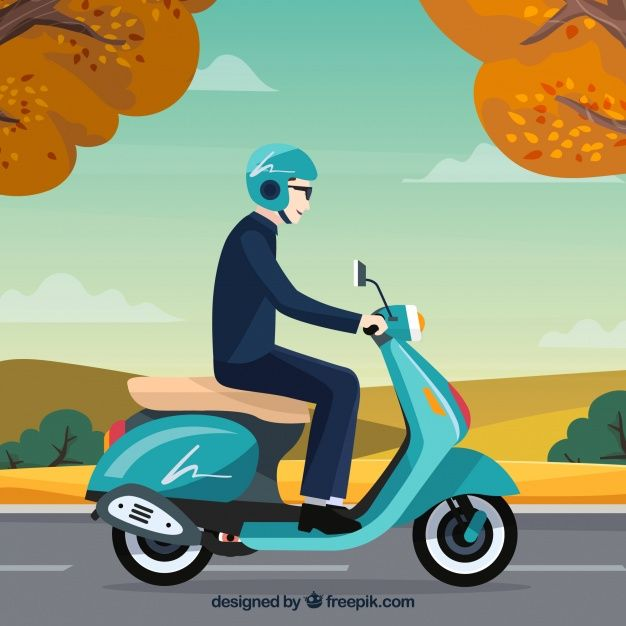

['A man in a red shirt is climbing a rock wall in front of',
 'A man in a white shirt is walking down a street in a black']

In [ ]:
captions, generated, image_matrix = caption_image(
    finetuned_model,  '/content/ev6.jpg'
)

captions

In [ ]:
/captions, generated, image_matrix = caption_image(
    finetuned_model,  '../data/rocks.jpg'
)

captions